<h1> Resolvable sources Plotter </h1> 

In the following, we'll implement a notebook to plot the distribution in redshift (together with its statistical uncertainties) of the resolvable sources for a _fiducial BBH_ population, together with the redshift distribution of resolvable sources coming from a _PBH_ subpopulation.  
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import os
import IPython
import pandas as pd
import pickle
import multiprocessing as mp
from tqdm import tqdm
import scipy.stats as scst
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
%run BigFont.py
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("seaborn-v0_8-white")

<h2> Loading the datasets </h2> 

The precomputed datasets can be loaded using:

In [2]:
# Loading the fiducial BBH population informations

#file_to_read = open("aplus_FidRedDis.p", "rb")
#Fid_P = pickle.load(file_to_read)

In [3]:
# Loading the fiducial BBH population informations

#file_to_read = open("aplus_SubPopRedDis.p", "rb")
#Sub_P = pickle.load(file_to_read)

In [4]:
Fid_Pop = {}
Sub_Pop = {}

In [5]:
# Here we select which is the user that generated the SNRs

#User = 'Paolo'
User = 'Mauro'

<h2> Loading the populations catalogues </h2> 

To begin, we can load the fiducial population catalogues as:

In [6]:
# Loading the aplus LIGO SNR Dataframes

N_cats = 100

LIGO_Fid = {}
ET_Fid = {}

if User == 'Mauro':
    inname = User + 'Cat/A+/Fiducial'
else:
    inname = User + 'Cat/SNRs/Fiducial'
    
for i in tqdm(range(1, N_cats + 1), dynamic_ncols=True):
        fname = inname + str(i) + '.pkl'
        LIGO_Fid[i] = pd.read_pickle(fname)

# Loading the ET SNR Dataframes
if User == 'Mauro':
    inname = User + 'Cat/ET/Fiducial'

for i in tqdm(range(1, N_cats + 1), dynamic_ncols=True):
        fname = inname + str(i) + '.pkl'
        ET_Fid[i] = pd.read_pickle(fname)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 279.50it/s]


the catalogues appears as follows:

In [7]:
LIGO_Fid[1]

,redshift,m1,m2,p_z,p_m1m2,t_c,phi_0,f_min,theta,phi,iota,psi,s1,s2,cosz1,cosz2,SNR
0,1.560272,132.091550,64.261001,0.399590,0.000007,0.019925,2.475267,0.065761,2.021715,2.865871,2.765790,0.459527,0.198022,0.299016,0.496723,0.811989,8.891975
1,6.022565,76.770180,45.503929,0.018650,0.001982,0.027175,4.736364,0.076967,0.498681,0.081150,1.229776,2.979236,0.219461,0.323015,0.487123,0.853190,0.490035
2,1.951501,105.378297,87.660598,0.395835,0.000369,0.063017,1.242252,0.041280,1.268783,0.797582,0.829124,0.185046,0.360822,0.444350,-0.341064,-0.594324,4.345989
3,2.418864,44.003082,32.945737,0.313170,0.007480,0.007904,6.149979,0.160516,2.906987,5.835633,0.832199,0.950355,0.329001,0.007917,0.323099,0.552249,2.734270
4,2.194429,22.961268,21.721550,0.358328,0.142193,0.064952,1.168016,0.101568,0.293436,3.699433,1.565590,1.258945,0.283208,0.272897,-0.397116,-0.662550,1.484334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81436,1.883150,28.262878,25.414684,0.402522,0.047234,0.024154,0.509470,0.131344,2.710922,4.935615,1.425174,1.603939,0.225825,0.225482,0.313024,0.942883,1.370079
81437,5.581832,113.060873,69.938163,0.025166,0.001368,0.012628,6.251639,0.079427,0.400213,0.353507,1.035326,0.063524,0.128200,0.227748,0.433952,0.910386,0.972214
81438,4.640682,159.078832,144.132708,0.050448,0.000470,0.035305,6.129528,0.038597,2.200048,4.316333,1.387447,2.405374,0.178217,0.286781,0.415000,0.521721,0.518614
81439,3.273903,77.341659,69.424400,0.157713,0.001602,0.028374,4.113495,0.065945,1.528523,4.723287,1.824218,0.238796,0.350470,0.240144,0.365614,0.967337,2.544749


We have to cut the events with SNR  smaller than $8$ from the two catalogues:

In [8]:
for i in tqdm(range(1, len(LIGO_Fid) + 1), dynamic_ncols=True):

    #Cutting the non-resolvable events from the A+ LIGO Cats for the fiducial model
    
    if User == 'Paolo':
        LIGO_Fid[i] = LIGO_Fid[i][LIGO_Fid[i].ApLIGO_minSNR >= 8.]
    
    if User == 'Mauro':
        LIGO_Fid[i] = LIGO_Fid[i][LIGO_Fid[i].SNR >= 8.]
    

    #Cutting the non-resolvable events from the ET Cats for the fiducial model
    
    if User == 'Paolo':
        ET_Fid[i] = ET_Fid[i][ET_Fid[i].ET_minSNR >= 8.]
    
    if User == 'Mauro':
        ET_Fid[i] = ET_Fid[i][ET_Fid[i].SNR >= 8.]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 122.55it/s]


The number of events on each catalogue now decreased:

In [9]:
LIGO_Fid[1]

,redshift,m1,m2,p_z,p_m1m2,t_c,phi_0,f_min,theta,phi,iota,psi,s1,s2,cosz1,cosz2,SNR
0,1.560272,132.091550,64.261001,0.399590,0.000007,0.019925,2.475267,0.065761,2.021715,2.865871,2.765790,0.459527,0.198022,0.299016,0.496723,0.811989,8.891975
58,0.441656,26.246089,20.881152,0.054624,0.001363,0.016830,0.865684,0.163770,0.792224,4.438281,1.409144,0.414817,0.202051,0.326813,0.798230,0.001275,14.929399
85,0.596575,56.189676,53.731684,0.099673,0.000449,0.015495,3.387803,0.099031,2.596037,5.954919,1.146211,0.858739,0.177744,0.381954,0.988090,0.163141,12.834965
136,0.725886,58.461260,50.853544,0.144603,0.000440,0.049627,2.174072,0.064330,0.935781,4.481355,2.484054,0.852733,0.501527,0.297187,-0.928274,0.690549,23.850333
164,0.792730,70.383163,40.755907,0.169546,0.000154,0.073749,0.352187,0.056315,2.513925,2.101196,1.629791,3.136314,0.426683,0.157349,0.318412,0.500598,10.759951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81299,1.079680,82.734032,81.936347,0.278655,0.000252,0.010640,3.870713,0.088554,1.130297,5.268734,1.039334,0.442754,0.202957,0.219867,0.654643,-0.098694,11.267229
81305,1.042382,31.991049,18.413119,0.265000,0.001972,0.030788,2.662446,0.128166,0.755153,4.562169,0.557356,2.965036,0.309519,0.125861,-0.173356,0.250994,8.930189
81386,0.495531,10.938685,10.358063,0.068990,0.146829,0.001234,4.479093,0.713475,1.375626,3.443370,0.305218,0.339683,0.315602,0.400349,-0.522225,0.824489,8.690571
81403,1.582265,95.972254,93.407011,0.401847,0.000375,0.039633,1.946431,0.049558,1.000708,4.412307,2.253180,2.091125,0.088112,0.378631,0.056293,0.619337,12.483918


We can then proceed by loading the subpopulations catalogues:

In [10]:
# Loading the aplus LIGO SNR Dataframes

LIGO_SPop1 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop1.pkl')
LIGO_SPop2 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop2.pkl')
LIGO_SPop3 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop3.pkl')
LIGO_SPop4 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop4.pkl')
LIGO_SPop5 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop5.pkl')
LIGO_SPop6 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop6.pkl')
LIGO_SPop7 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop7.pkl')
LIGO_SPop8 = pd.read_pickle(User + 'Cat/SubPop/A+/SubPop8.pkl')

# Loading the ET SNR Dataframes

ET_SPop1 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop1.pkl')
ET_SPop2 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop2.pkl')
ET_SPop3 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop3.pkl')
ET_SPop4 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop4.pkl')
ET_SPop5 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop5.pkl')
ET_SPop6 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop6.pkl')
ET_SPop7 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop7.pkl')
ET_SPop8 = pd.read_pickle(User + 'Cat/SubPop/ET/SubPop8.pkl')

And if the user is Paolo we have to rename some columns by doing:

In [11]:
# Renaming the columns in the dataframes

if User == 'Paolo':

    LIGO_SPop1.rename(columns = {'Redshift':'redshift'}, inplace = True)
    LIGO_SPop2.rename(columns = {'Redshift':'redshift'}, inplace = True)
    LIGO_SPop3.rename(columns = {'Redshift':'redshift'}, inplace = True)
    LIGO_SPop4.rename(columns = {'Redshift':'redshift'}, inplace = True)
    LIGO_SPop5.rename(columns = {'Redshift':'redshift'}, inplace = True)
    LIGO_SPop6.rename(columns = {'Redshift':'redshift'}, inplace = True)
    LIGO_SPop7.rename(columns = {'Redshift':'redshift'}, inplace = True)
    LIGO_SPop8.rename(columns = {'Redshift':'redshift'}, inplace = True)

    ET_SPop1.rename(columns = {'Redshift':'redshift'}, inplace = True)
    ET_SPop2.rename(columns = {'Redshift':'redshift'}, inplace = True)
    ET_SPop3.rename(columns = {'Redshift':'redshift'}, inplace = True)
    ET_SPop4.rename(columns = {'Redshift':'redshift'}, inplace = True)
    ET_SPop5.rename(columns = {'Redshift':'redshift'}, inplace = True)
    ET_SPop6.rename(columns = {'Redshift':'redshift'}, inplace = True)
    ET_SPop7.rename(columns = {'Redshift':'redshift'}, inplace = True)
    ET_SPop8.rename(columns = {'Redshift':'redshift'}, inplace = True)

The subpop catalogues appear as:

In [12]:
LIGO_SPop1

,redshift,m1,m2,p_event,t_c,phi_0,f_min,theta,phi,iota,psi,s1,s2,cosz1,cosz2,SNR
0,2.598318,296.315277,293.830536,0.543241,0.482229,0.014112,0.009543,1.990497,5.838261,1.468268,2.824923,0.163145,0.385512,-0.780863,0.270384,1.325873
1,2.224514,269.359924,255.546326,0.469543,0.985517,0.970192,0.007856,2.523425,0.869939,0.536214,0.862010,0.266541,0.123572,0.742322,-0.019474,13.910898
2,7.295702,707.649902,706.248291,0.045990,0.829797,0.513334,0.004510,1.329204,1.358602,1.015771,4.167375,0.431923,0.684478,0.327177,0.126016,0.649296
3,0.882175,166.306839,145.061066,0.036579,0.409017,0.590271,0.015165,2.030982,6.023305,1.974933,6.174930,0.118297,0.311891,-0.400639,0.890250,8.575805
4,1.233893,194.633133,177.710907,0.309899,0.565075,0.526891,0.012001,1.550573,0.359025,1.676577,1.007615,0.275926,0.034202,0.367109,0.498976,7.592908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,9.660380,1318.046265,1076.777832,0.386513,0.694218,0.134371,0.003482,1.675607,4.557669,1.244143,2.867323,0.101178,0.136367,0.744663,0.712710,0.122041
676,8.117452,1165.087646,846.131287,0.106909,0.370499,0.384565,0.004943,2.096440,0.793247,2.675774,4.723047,0.189233,0.163680,0.936995,0.394749,0.444355
677,7.868308,1139.401855,765.559998,0.721728,0.957934,0.220091,0.003599,0.887107,0.245405,2.016712,0.173395,0.137309,0.353716,0.193522,0.951558,0.182666
678,8.331067,1188.041138,927.657227,0.940116,0.177313,0.102911,0.006289,1.700124,3.099094,1.580604,6.259885,0.383991,0.216736,-0.319270,0.316693,0.070516


To conclude, if the user is Mauro we have to cut the non-resolvable events by doing:

In [13]:
if User == 'Mauro':

    #Cutting the non-resolvable events from the A+ LIGO Cats for the sub-populations

    LIGO_SPop1 = LIGO_SPop1[LIGO_SPop1.SNR >= 8.]
    LIGO_SPop2 = LIGO_SPop2[LIGO_SPop2.SNR >= 8.]
    LIGO_SPop3 = LIGO_SPop3[LIGO_SPop3.SNR >= 8.]
    LIGO_SPop4 = LIGO_SPop4[LIGO_SPop4.SNR >= 8.]
    LIGO_SPop5 = LIGO_SPop5[LIGO_SPop5.SNR >= 8.]
    LIGO_SPop6 = LIGO_SPop6[LIGO_SPop6.SNR >= 8.]
    LIGO_SPop7 = LIGO_SPop7[LIGO_SPop7.SNR >= 8.]
    LIGO_SPop8 = LIGO_SPop8[LIGO_SPop8.SNR >= 8.]

    #Cutting the non-resolvable events from the ET Cats for the sub-populations

    ET_SPop1 = ET_SPop1[ET_SPop1.SNR >= 8.]
    ET_SPop2 = ET_SPop2[ET_SPop2.SNR >= 8.]
    ET_SPop3 = ET_SPop3[ET_SPop3.SNR >= 8.]
    ET_SPop4 = ET_SPop4[ET_SPop4.SNR >= 8.]
    ET_SPop5 = ET_SPop5[ET_SPop5.SNR >= 8.]
    ET_SPop6 = ET_SPop6[ET_SPop6.SNR >= 8.]
    ET_SPop7 = ET_SPop7[ET_SPop7.SNR >= 8.]
    ET_SPop8 = ET_SPop8[ET_SPop8.SNR >= 8.]

<h2> Building the hystograms with different redshift spacing </h2> 

The hystograms will be built with the following different redshift spacing:

In [14]:
# Linear binning

bin_lin = np.linspace(0.,10.,300) # 0.02 spacing to shows the properties of the redshift distribution of the resolvable sources
bin_mlin = 0.5*(bin_lin[1::] + bin_lin[:-1:])
dbin_lin = (bin_lin[1::] - bin_lin[:-1:])

# Logarithmic binning

bin_log = np.logspace(-2., 1, 60) # approximately 10% error in function of z on each bin, grows with z
bin_mlog = 0.5*(bin_log[1::] + bin_log[:-1:])
dbin_log = (bin_log[1::] - bin_log[:-1:])

simply by saving the output of the matplotlib hystrograms:

<h4> Hystograms for the fiducial populations </h4> 

In [15]:
Fid_Pop  = {}

100%|█████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


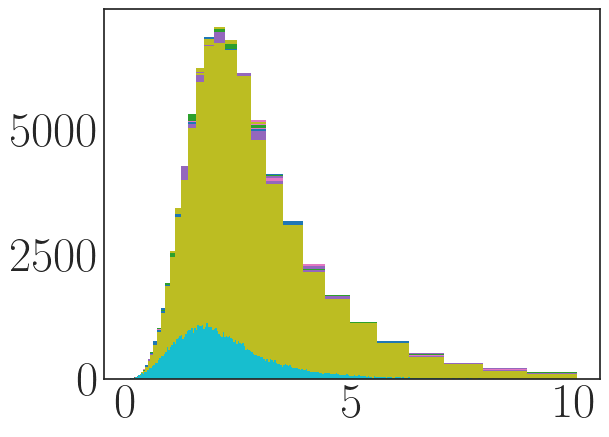

In [16]:
for i in tqdm(range(1, len(LIGO_Fid) + 1), dynamic_ncols=True):
    
    LIGO_vallog, bins, patches = plt.hist(LIGO_Fid[i].redshift, bins=bin_log) # Values for logarithmic binning for LIGO
    LIGO_vallin, bins, patches = plt.hist(LIGO_Fid[i].redshift, bins=bin_lin) # Values for linear binning for LIGO
    
    ET_vallog, bins, patches = plt.hist(ET_Fid[i].redshift, bins=bin_log) # Values for logarithmic binning for LIGO
    ET_vallin, bins, patches = plt.hist(ET_Fid[i].redshift, bins=bin_lin) # Values for linear binning for LIGO
    
    Fid_Pop[i] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}





<h4> Hystograms for the sub-populations </h4> 

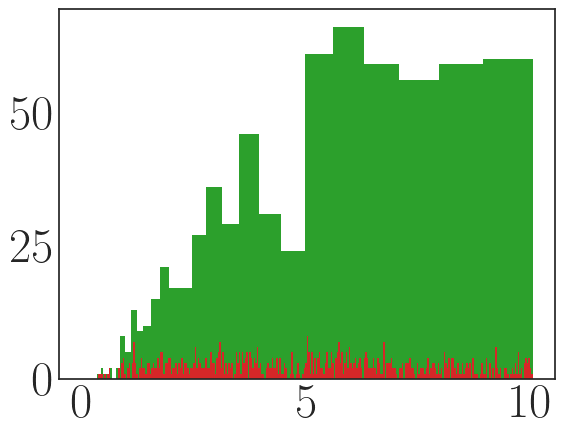

In [17]:
#      THIS IS SubPop 1  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop1.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop1.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop1.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop1.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point1'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

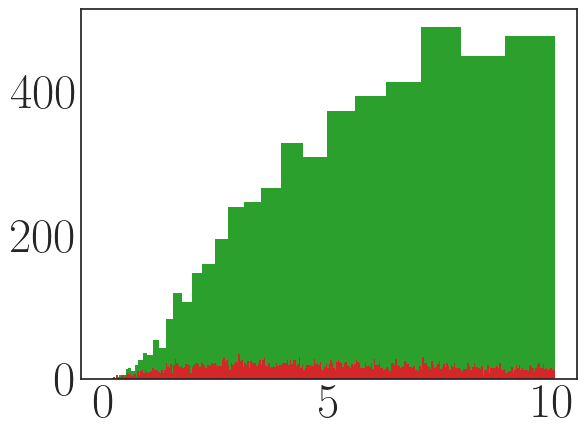

In [18]:
#      THIS IS SubPop 2  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop2.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop2.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop2.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop2.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point2'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

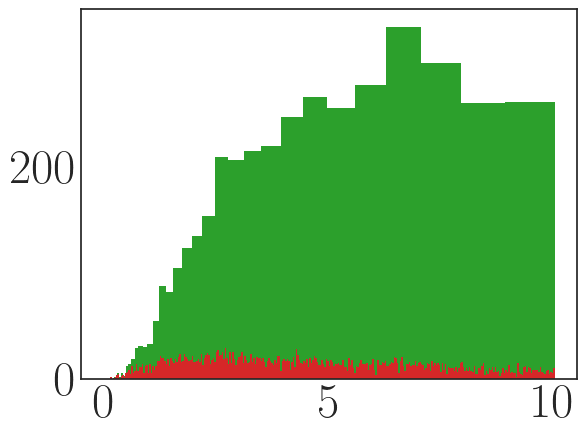

In [19]:
#      THIS IS SubPop 3  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop3.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop3.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop3.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop3.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point3'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

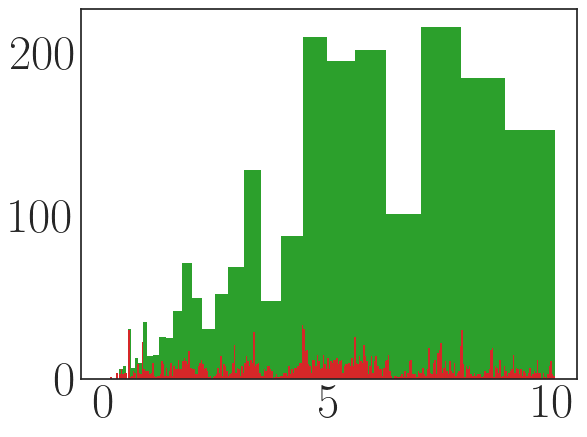

In [20]:
#      THIS IS SubPop 4  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop4.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop4.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop4.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop4.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point4'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

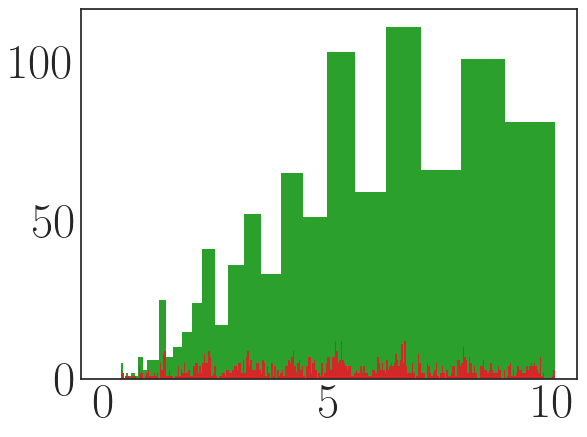

In [21]:
#      THIS IS SubPop 5  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop5.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop5.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop5.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop5.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point5'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

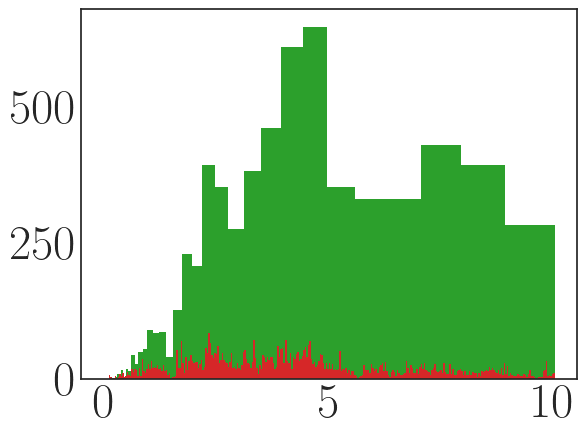

In [22]:
#      THIS IS SubPop 6  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop6.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop6.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop6.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop6.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point6'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

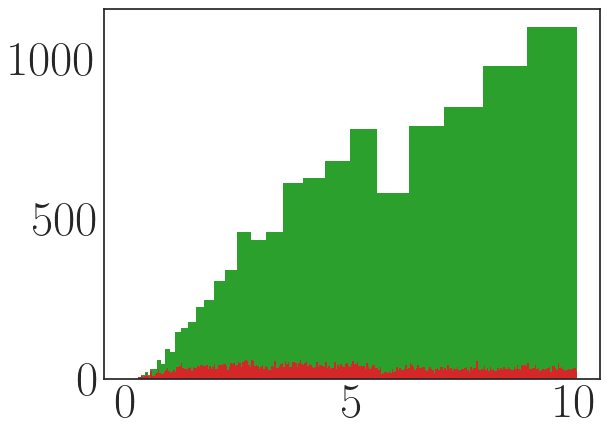

In [23]:
#      THIS IS SubPop 7  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop7.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop7.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop7.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop7.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point7'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

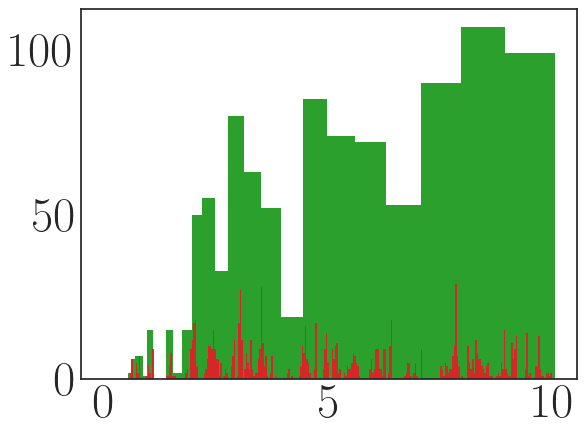

In [24]:
#      THIS IS SubPop 8  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop8.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop8.redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop8.redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop8.redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point8'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

<h2> Statistical analysis of the fiducial population </h2> 

Given the whole set of fiducial population realization, we can obtain some statistical quantities describing the latter as :

In [25]:
# Estimating the average and sigma in each bin 

# Defining the variables for the linear redshift span

LIGO_avglin = np.linspace(0., 1., len(Fid_Pop[1]['Red_lin']['Redshift']))*0.
LIGO_siglin = np.linspace(0., 1., len(Fid_Pop[1]['Red_lin']['Redshift']))*0.

ET_avglin = np.linspace(0., 1., len(Fid_Pop[1]['Red_lin']['Redshift']))*0.
ET_siglin = np.linspace(0., 1., len(Fid_Pop[1]['Red_lin']['Redshift']))*0.

# Defining the variables for the logarithmic redshift span

LIGO_avglog = np.linspace(0., 1., len(Fid_Pop[1]['Red_log']['Redshift']))*0.
LIGO_siglog = np.linspace(0., 1., len(Fid_Pop[1]['Red_log']['Redshift']))*0.

ET_avglog = np.linspace(0., 1., len(Fid_Pop[1]['Red_log']['Redshift']))*0.
ET_siglog = np.linspace(0., 1., len(Fid_Pop[1]['Red_log']['Redshift']))*0.


In [26]:
# Estimating the avg values for linear redshift binning

for i in tqdm(range(len(Fid_Pop[1]['Red_lin']['Redshift']))):
    for j in range(1, len(LIGO_Fid) + 1):
        LIGO_avglin[i] += (1./float(N_cats))*Fid_Pop[j]['Red_lin']['LIGO_ResEvents'][i] 
        ET_avglin[i] += (1./float(N_cats))*Fid_Pop[j]['Red_lin']['ET_ResEvents'][i] 

100%|███████████████████████████████████████| 299/299 [00:00<00:00, 8437.14it/s]


In [27]:
# Estimating the avg values for logarithmic redshift binning

for i in tqdm(range(len(Fid_Pop[1]['Red_log']['Redshift']))):
    for j in range(1, len(LIGO_Fid) + 1):        
        LIGO_avglog[i] += (1./float(N_cats))*Fid_Pop[j]['Red_log']['LIGO_ResEvents'][i]
        ET_avglog[i] += (1./float(N_cats))*Fid_Pop[j]['Red_log']['ET_ResEvents'][i]   

100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 8827.28it/s]


In [28]:
# Estimating the sigmas for linear redshift binning

for i in tqdm(range(len(Fid_Pop[1]['Red_lin']['Redshift']))):
    for j in range(1, len(LIGO_Fid) + 1):
        LIGO_siglin[i] += (1./float(N_cats - 1))*dbin_lin[i]*(Fid_Pop[j]['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2.
        ET_siglin[i] += (1./float(N_cats - 1))*dbin_lin[i]*(Fid_Pop[j]['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2.
    
    LIGO_siglin[i] = np.sqrt(LIGO_siglin[i])
    ET_siglin[i] = np.sqrt(ET_siglin[i])

100%|███████████████████████████████████████| 299/299 [00:00<00:00, 3417.59it/s]


In [29]:
# Estimating here the sigmas for logarithmic redshift binning

for i in tqdm(range(len(Fid_Pop[1]['Red_log']['Redshift']))):
    for j in range(1, len(LIGO_Fid) + 1):
        
        LIGO_siglog[i] += (1./float(N_cats - 1))*dbin_log[i]*(Fid_Pop[j]['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2.
        ET_siglog[i] += (1./float(N_cats - 1))*dbin_log[i]*(Fid_Pop[j]['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2.
    
    LIGO_siglog[i] = np.sqrt(LIGO_siglog[i])
    ET_siglog[i] = np.sqrt(ET_siglog[i])

100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 5156.04it/s]


we can now save the statistical results :

In [30]:
Fid_Pop['apLIGO_StatAnal'] = {'Red_lin':{'Redshift': bin_mlin, 'Avg': LIGO_avglin, 'Sigma' : LIGO_siglin, 'SigP1' : LIGO_avglin + LIGO_siglin, 'SigM1' : LIGO_avglin - LIGO_siglin, 'SigP3' : LIGO_avglin + 3.*LIGO_siglin , 'SigM3' : LIGO_avglin - 3.*LIGO_siglin}, 'Red_log':{'Redshift': bin_mlog, 'Avg': LIGO_avglog, 'Sigma' : LIGO_siglog, 'SigP1' : LIGO_avglog + LIGO_siglog, 'SigM1' : LIGO_avglog - LIGO_siglog, 'SigP3' : LIGO_avglog + 3.*LIGO_siglog , 'SigM3' : LIGO_avglog - 3.*LIGO_siglog}}
Fid_Pop['ET_StatAnal'] = {'Red_lin':{'Redshift': bin_mlin, 'Avg': ET_avglin, 'Sigma' : ET_siglin, 'SigP1' : ET_avglin + ET_siglin, 'SigM1' : ET_avglin - ET_siglin, 'SigP3' : ET_avglin + 3.*ET_siglin , 'SigM3' : ET_avglin - 3.*ET_siglin}, 'Red_log':{'Redshift': bin_mlog, 'Avg': ET_avglog, 'Sigma' : ET_siglog, 'SigP1' : ET_avglog + ET_siglog, 'SigM1' : ET_avglog - ET_siglog, 'SigP3' : ET_avglog + 3.*ET_siglog , 'SigM3' : ET_avglog - 3.*ET_siglog}}

<h2> Saving the obtained dataframes </h2>

We can now save the save the obtained dataframes by running:

In [31]:
fname = 'CatStatAnal.pkl'
fname = User + fname

with open(fname, 'wb') as file:
    pickle.dump(Fid_Pop, file, protocol=pickle.HIGHEST_PROTOCOL)

<h2> Plotting the results for aplus LIGO </h2>

In [32]:
# Plotting the results for the LogNormal subpopulation

if User == 'Paolo':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP3'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP1'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\hat{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point1']['Red_log']['LIGO_ResEvents'], color = 'Indigo', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 1}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point2']['Red_log']['LIGO_ResEvents'], color = 'mediumorchid', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 2}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point3']['Red_log']['LIGO_ResEvents'], color = 'turquoise', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 3}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point4']['Red_log']['LIGO_ResEvents'], color = 'lime', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 4}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 2.2)
    plt.yscale('log')
    plt.ylim(1.e0,1.e4)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm LN}, \, \rm LIGO \, A^{+}, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('apLIGOSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=200)
    #plt.savefig('apLIGOSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=50)

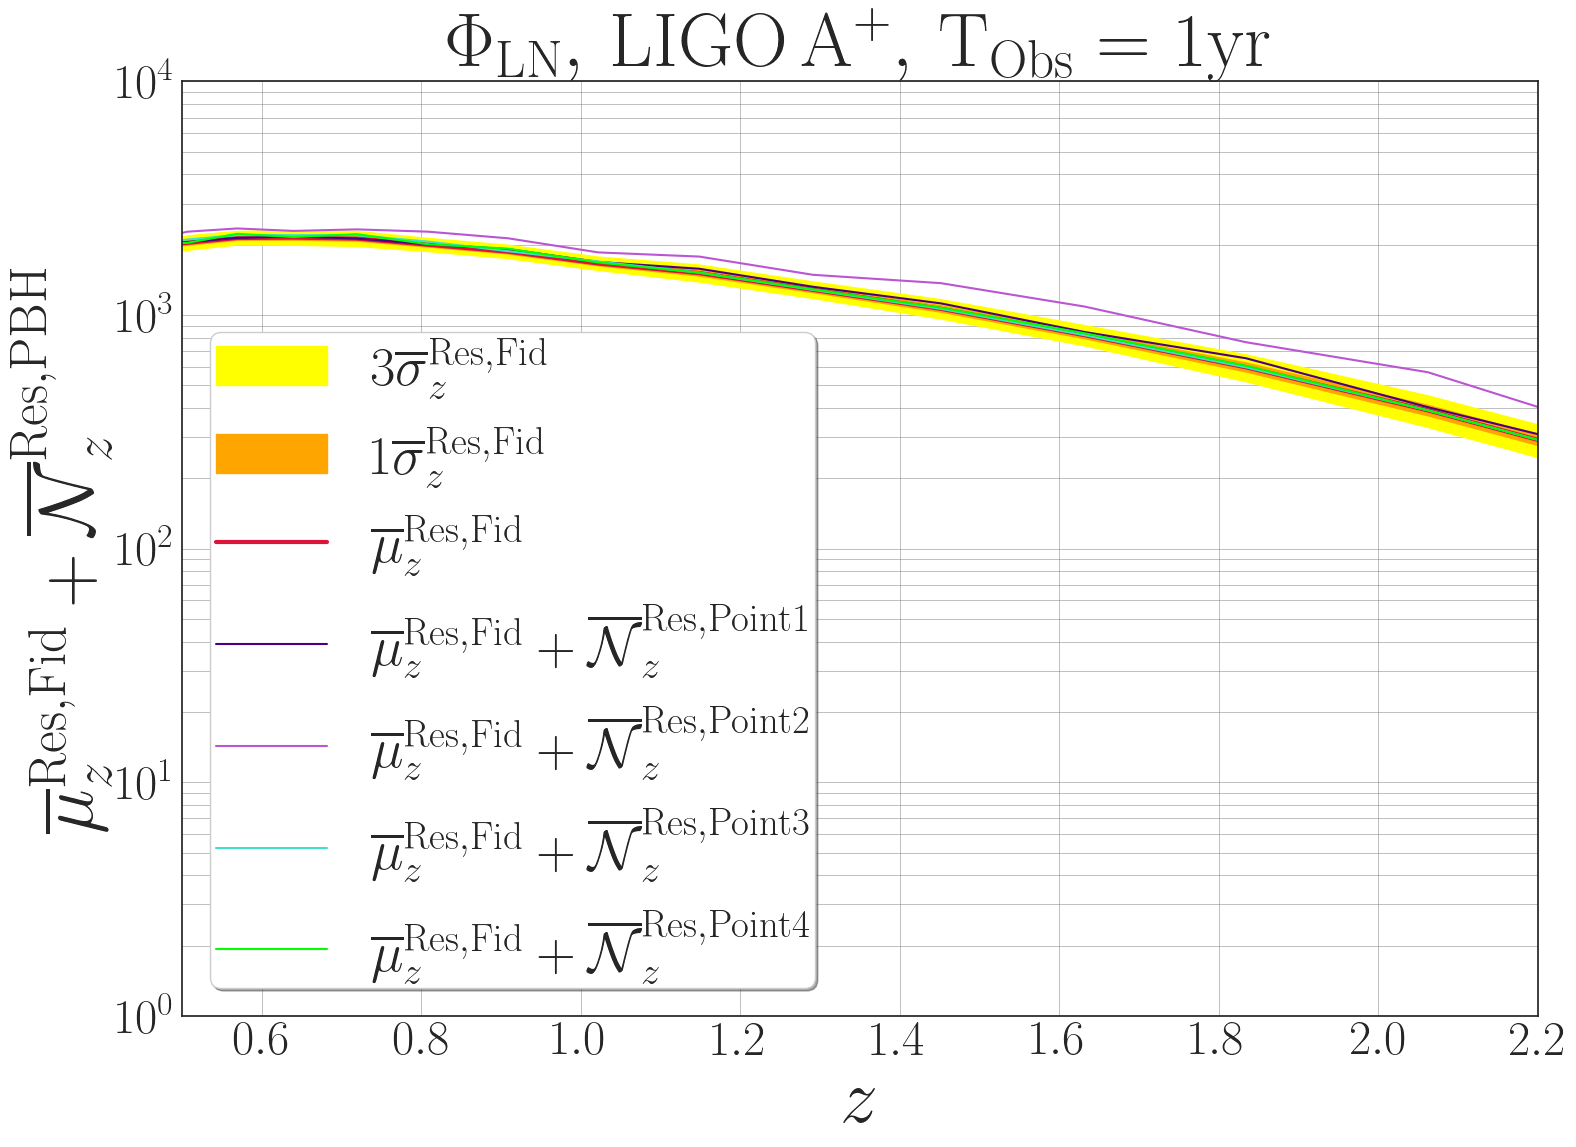

In [33]:
# Plotting the results for the LogNormal subpopulation

if User == 'Mauro':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP3'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP1'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\overline{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point1']['Red_log']['LIGO_ResEvents'], color = 'Indigo', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 1}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point2']['Red_log']['LIGO_ResEvents'], color = 'mediumorchid', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 2}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point3']['Red_log']['LIGO_ResEvents'], color = 'turquoise', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 3}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point4']['Red_log']['LIGO_ResEvents'], color = 'lime', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 4}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 2.2)
    plt.yscale('log')
    plt.ylim(1.e0,1.e4)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm LN}, \, \rm LIGO \, A^{+}, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('MauroapLIGOSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=200)
    #plt.savefig('MauroapLIGOSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=50)

In [34]:
# Plotting the results for the Gaussian subpopulation

if User == 'Paolo':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP3'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP1'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\hat{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point5']['Red_log']['LIGO_ResEvents'], color = 'Indigo', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 5}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point6']['Red_log']['LIGO_ResEvents'], color = 'mediumorchid', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 6}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point7']['Red_log']['LIGO_ResEvents'], color = 'turquoise', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 7}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point8']['Red_log']['LIGO_ResEvents'], color = 'lime', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 8}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 2.2)
    plt.yscale('log')
    plt.ylim(1.e0,1.e4)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm G}, \, \rm LIGO \, A^{+}, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('apLIGOSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=200)
    #plt.savefig('apLIGOSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=50)

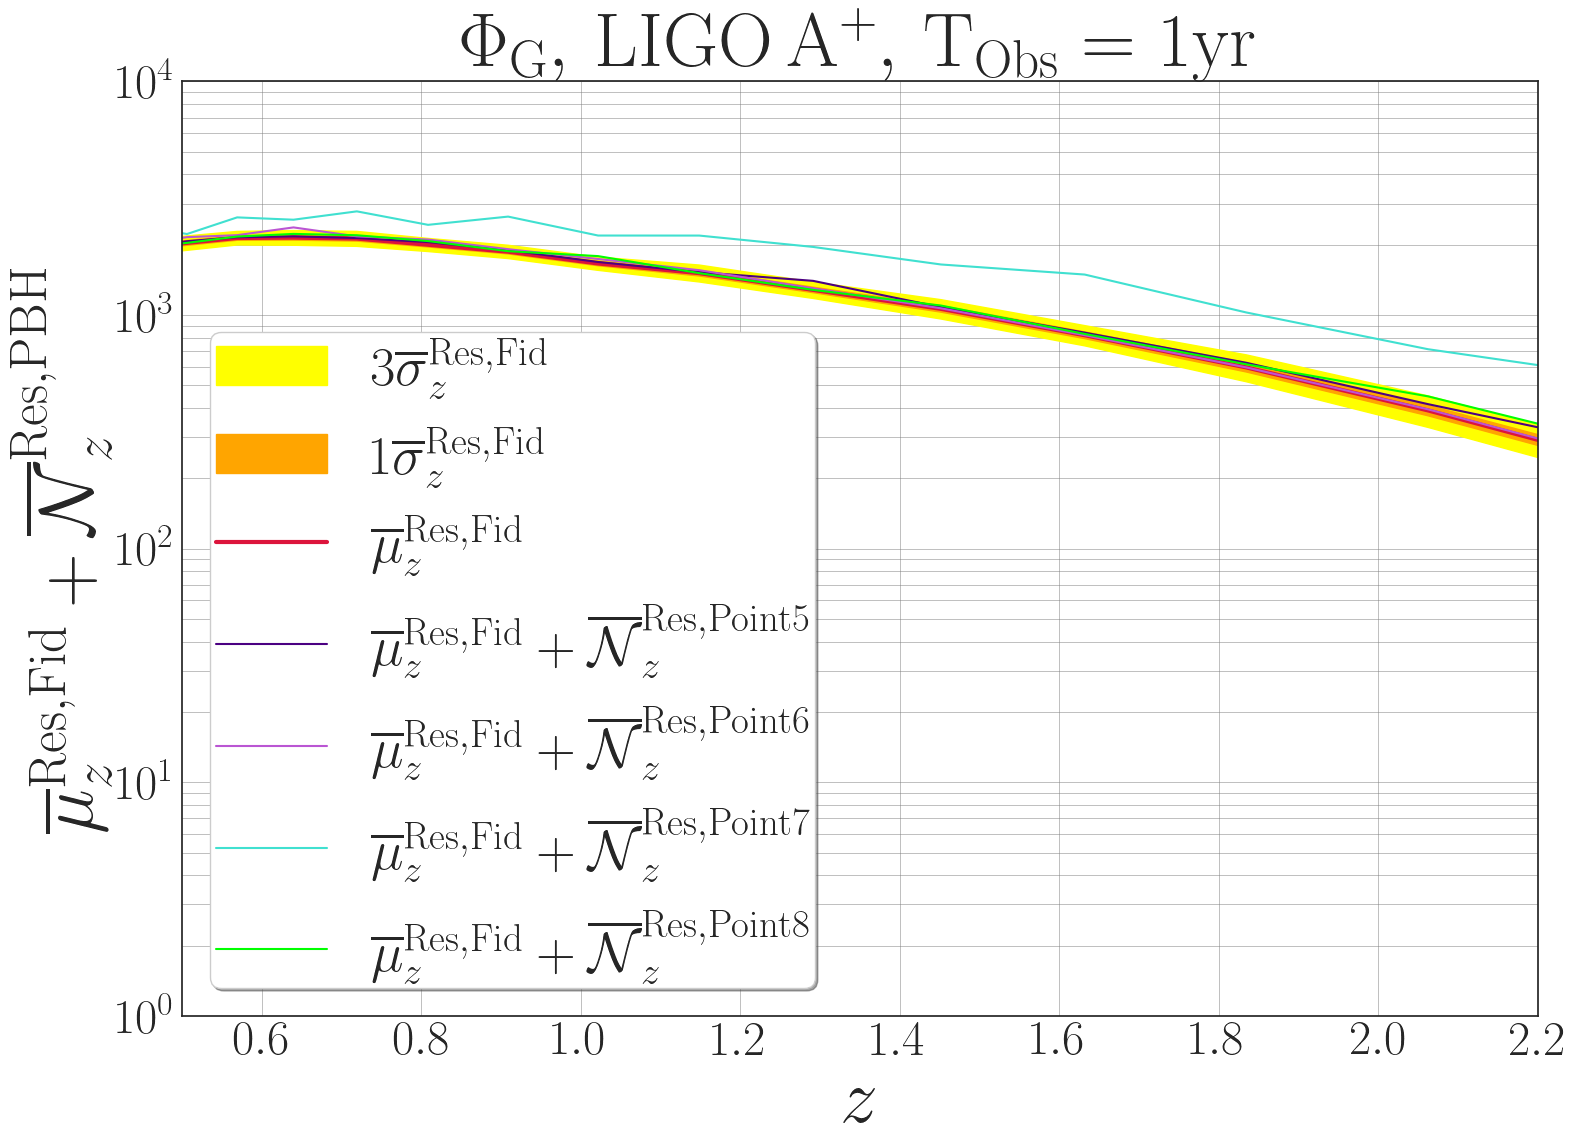

In [35]:
# Plotting the results for the Gaussian subpopulation

if User == 'Mauro':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP3'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP1'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\overline{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point5']['Red_log']['LIGO_ResEvents'], color = 'Indigo', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 5}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point6']['Red_log']['LIGO_ResEvents'], color = 'mediumorchid', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 6}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point7']['Red_log']['LIGO_ResEvents'], color = 'turquoise', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 7}$')
    plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point8']['Red_log']['LIGO_ResEvents'], color = 'lime', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 8}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 2.2)
    plt.yscale('log')
    plt.ylim(1.e0,1.e4)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm G}, \, \rm LIGO \, A^{+}, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('MauroapLIGOSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=200)
    #plt.savefig('MauroapLIGOSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=50)

<h2> Plotting the results for ET </h2>

In [36]:
# Plotting the results for the LogNormal subpopulation
if User == 'Paolo':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP3'], Fid_Pop['ET_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP1'], Fid_Pop['ET_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\hat{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point1']['Red_log']['ET_ResEvents'], color = 'Indigo', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 1}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point2']['Red_log']['ET_ResEvents'], color = 'mediumorchid', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 2}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point3']['Red_log']['ET_ResEvents'], color = 'turquoise', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 3}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point4']['Red_log']['ET_ResEvents'], color = 'lime', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 4}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 10.)
    plt.yscale('log')
    plt.ylim(1.e0,1.e5)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm LN}, \, \rm ET, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('ETSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=200)
    #plt.savefig('ETSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=50)

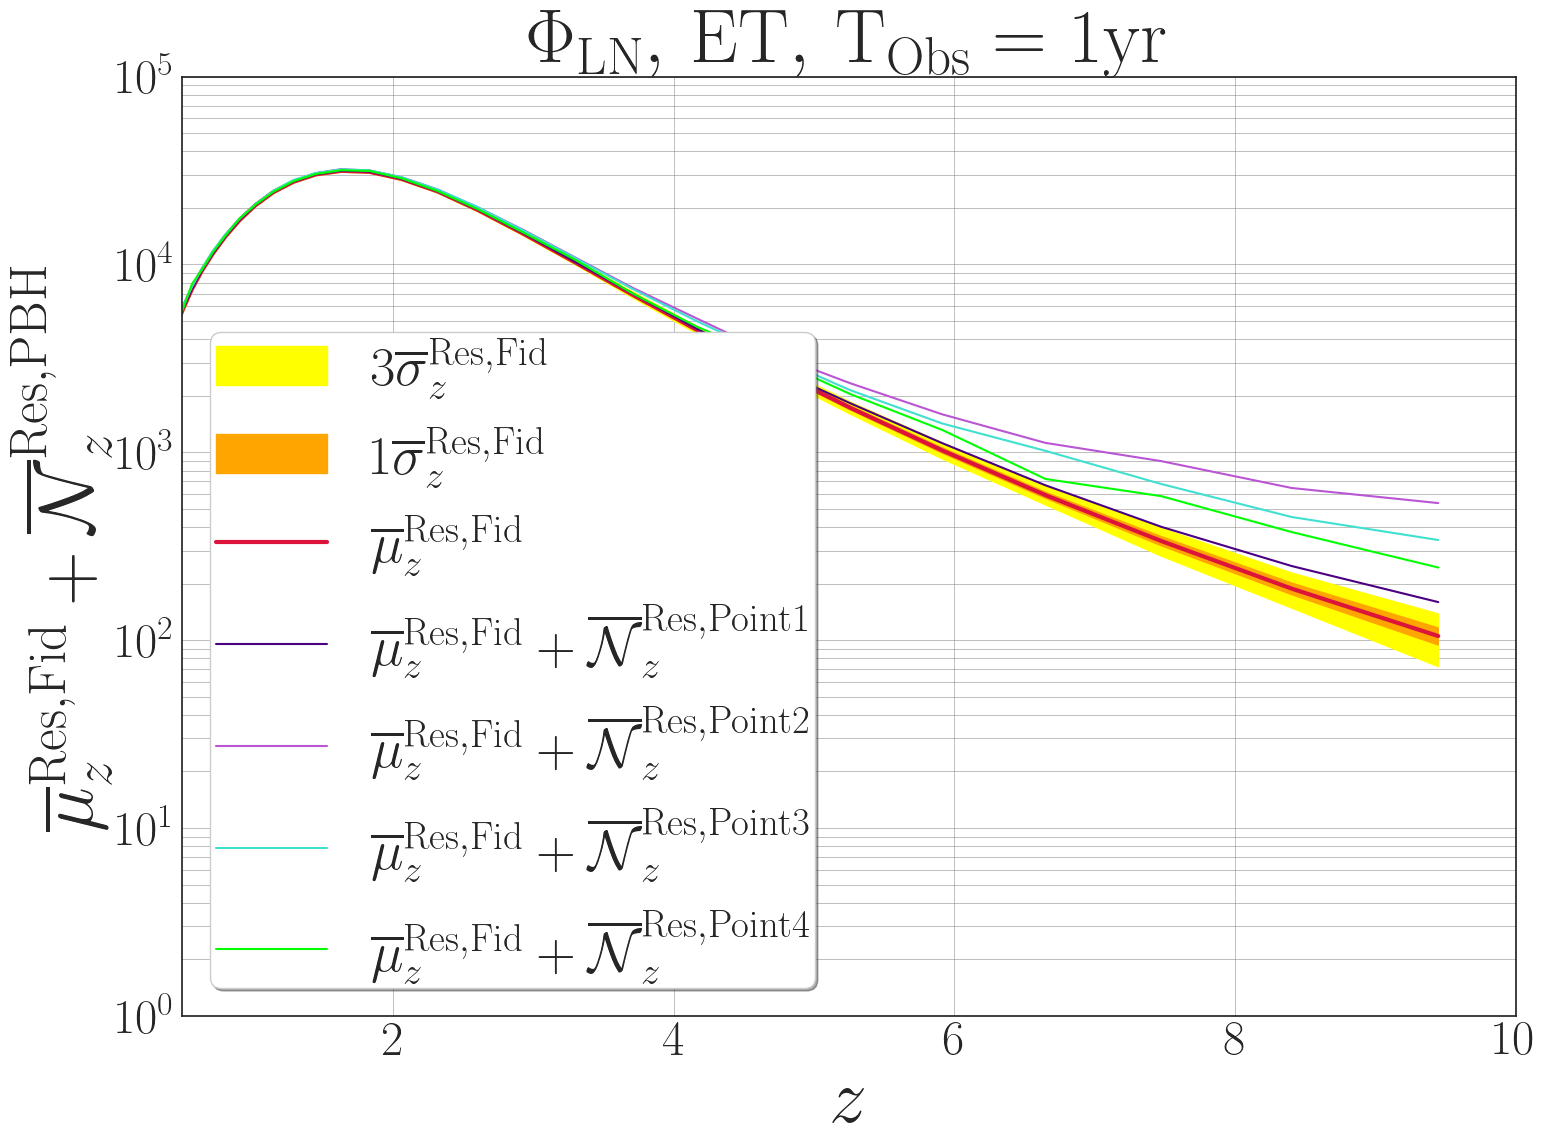

In [37]:
# Plotting the results for the LogNormal subpopulation
if User == 'Mauro':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP3'], Fid_Pop['ET_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP1'], Fid_Pop['ET_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\overline{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point1']['Red_log']['ET_ResEvents'], color = 'Indigo', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 1}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point2']['Red_log']['ET_ResEvents'], color = 'mediumorchid', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 2}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point3']['Red_log']['ET_ResEvents'], color = 'turquoise', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 3}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point4']['Red_log']['ET_ResEvents'], color = 'lime', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 4}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 10.)
    plt.yscale('log')
    plt.ylim(1.e0,1.e5)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm LN}, \, \rm ET, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('MauroETSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=200)
    #plt.savefig('MauroETSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=50)

In [38]:
# Plotting the results for the Gaussian subpopulation
if User == 'Paolo':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP3'], Fid_Pop['ET_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP1'], Fid_Pop['ET_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\hat{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\hat{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point5']['Red_log']['ET_ResEvents'], color = 'Indigo', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 5}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point6']['Red_log']['ET_ResEvents'], color = 'mediumorchid', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 6}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point7']['Red_log']['ET_ResEvents'], color = 'turquoise', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 7}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point8']['Red_log']['ET_ResEvents'], color = 'lime', label = r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, Point 8}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\hat{\mu}_z^{\rm Res, Fid} + \hat{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 10.)
    plt.yscale('log')
    plt.ylim(1.e0,1.e5)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm G}, \, \rm ET, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('ETSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=200)
    #plt.savefig('ETSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=50)

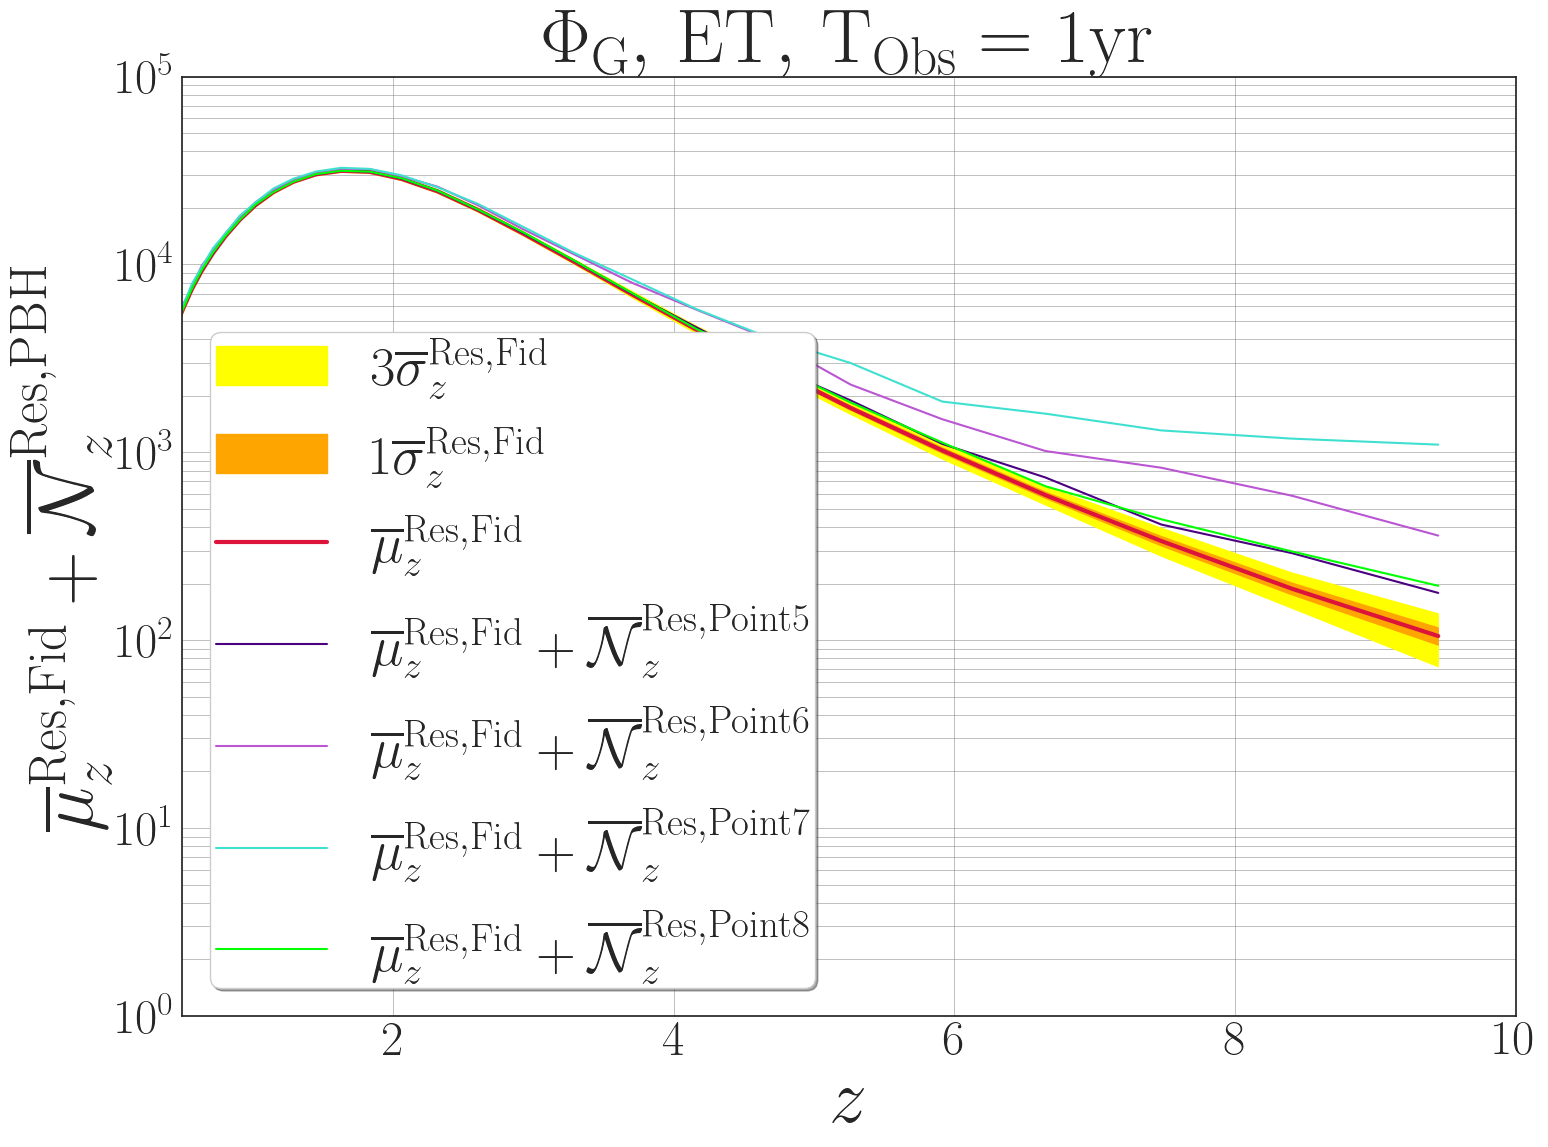

In [39]:
# Plotting the results for the Gaussian subpopulation
if User == 'Mauro':
    plt.figure(figsize=(16,12))
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP3'], Fid_Pop['ET_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP1'], Fid_Pop['ET_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\overline{\sigma}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = r'$\overline{\mu}_z^{\rm Res, Fid}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point5']['Red_log']['ET_ResEvents'], color = 'Indigo', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 5}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point6']['Red_log']['ET_ResEvents'], color = 'mediumorchid', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 6}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point7']['Red_log']['ET_ResEvents'], color = 'turquoise', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 7}$')
    plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point8']['Red_log']['ET_ResEvents'], color = 'lime', label = r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, Point 8}$')
    plt.xlabel('$z$', fontsize = 55 )
    plt.ylabel(r'$\overline{\mu}_z^{\rm Res, Fid} + \overline{\mathcal{N}}_z^{\rm Res, PBH}$', fontsize = 55)
    plt.xlim(0.5, 10.)
    plt.yscale('log')
    plt.ylim(1.e0,1.e5)
    plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 40})
    #plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
    plt.title(r'$\Phi_{\rm G}, \, \rm ET, \, T_{\rm Obs} = 1yr$',fontsize = 55)
    plt.tight_layout()
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
    plt.savefig('MauroETSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=200)
    #plt.savefig('MauroETSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=50)